In [ ]:
pip install tensorflow_text

In [ ]:
import numpy as np
from numpy import asarray
from numpy import zeros
import pandas as pd
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
import nltk
from keras.models import Sequential
from keras.utils import to_categorical
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW 



In [ ]:
!gdown 1-F7f9oSjFx0Si44DvdkzFhjjwfro_Y1p

Downloading...
From: https://drive.google.com/uc?id=1-F7f9oSjFx0Si44DvdkzFhjjwfro_Y1p
To: /content/train_data.csv
100% 635M/635M [00:05<00:00, 107MB/s] 


In [ ]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
train = train[["reviewText", "overall"]]
test = test[["reviewText"]]

<ipython-input-5-0c83f4350de4>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train_data.csv")


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


undersampler = RandomUnderSampler(sampling_strategy={1: 80000, 2: 50000, 3: 80000, 4: 99999, 5: 99999}, random_state=78)
oversampler = RandomOverSampler(sampling_strategy={1: 100000, 2: 100000, 3: 100000, 4: 100000, 5: 100000}, random_state=78)

X_resampled, y_resampled = undersampler.fit_resample(train.drop(columns=["overall"]), train['overall'])
X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (100000) in class 1 will be larger than the number of samples in the majority class (class #4 -> 99999)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (100000) in class 2 will be larger than the number of samples in the majority class (class #4 -> 99999)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (100000) in class 3 will be larger than the number of samples in the majority class (class #4 -> 99999)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (100000) in class 4 will be larger than the number of samples in the majority class (class #4 -> 99999)
  warning

In [ ]:
from keras.utils import to_categorical
y_resampled -= 1
y_onehot = to_categorical(y_resampled)
y_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_onehot, shuffle=True)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
opt=tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="AdamW")

In [ ]:
classifier_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

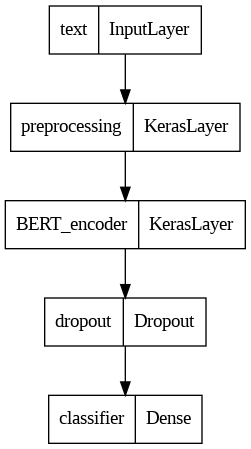

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.1)

Epoch 1/5
1319/1319 [==============================] - 6411s 5s/step - loss: 1.1823 - accuracy: 0.4872 - val_loss: 1.0715 - val_accuracy: 0.5441
Epoch 2/5
1319/1319 [==============================] - 6324s 5s/step - loss: 1.0320 - accuracy: 0.5619 - val_loss: 1.0376 - val_accuracy: 0.5648
Epoch 3/5
1031/1319 [======================>.......] - ETA: 22:33 - loss: 0.9530 - accuracy: 0.6042

KeyboardInterrupt: ignored

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=1)

3907/3907 [==============================] - 632s 162ms/step - loss: 1.0257 - accuracy: 0.5750


[1.0257203578948975, 0.5750319957733154]

In [ ]:
ans = classifier_model.predict(X_test, verbose=1)
max_indices = np.argmax(ans, axis=1)
zeros_array = np.zeros_like(ans)
zeros_array[np.arange(len(ans)), max_indices] = 1
indices = np.argwhere(zeros_array == 1)
indices = indices[:, 1]
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, indices, average='micro')
recall = recall_score(y_test, indices, average='micro')
f1 = f1_score(y_test, indices, average='micro')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.57
Recall: 0.57
F1 Score: 0.57


In [ ]:
classifier_model.save("BERT")

<h3 align=left style="line-height:500%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Conclusion:
</font>
</h3>

Now that we have seen different models working, we can go for our final decision:

In [ ]:
ans = classifier_model.predict(test, verbose=1)
ans

625/625 [==============================] - 103s 164ms/step


array([[0.89887357, 0.8692897 , 0.66234344, 0.20995487, 0.05165909],
       [0.85880446, 0.40975046, 0.42182538, 0.26769918, 0.27971542],
       [0.92199224, 0.90917414, 0.7286272 , 0.15283124, 0.0267827 ],
       ...,
       [0.05146775, 0.04701315, 0.22633538, 0.8628955 , 0.99428874],
       [0.7977451 , 0.8236216 , 0.63415664, 0.28102174, 0.10477881],
       [0.31398368, 0.2006235 , 0.35662216, 0.59431154, 0.6965828 ]],
      dtype=float32)

In [ ]:
max_indices = np.argmax(ans, axis=1)
zeros_array = np.zeros_like(ans)
zeros_array[np.arange(len(ans)), max_indices] = 1
zeros_array

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
indices = np.argwhere(zeros_array == 1) + 1
indices

array([[    1,     1],
       [    2,     1],
       [    3,     1],
       ...,
       [19998,     5],
       [19999,     2],
       [20000,     5]])

array([[<Axes: title={'center': 'predicted'}>]], dtype=object)

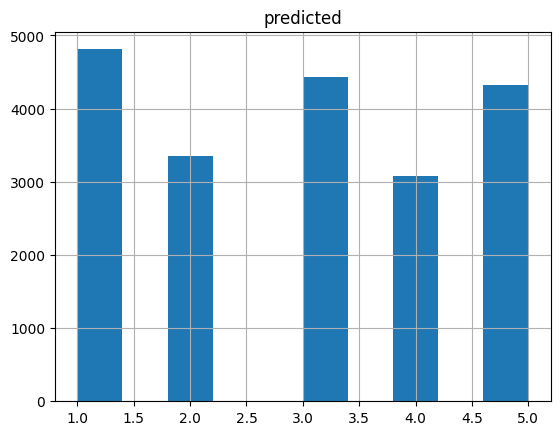

In [ ]:
df = pd.DataFrame({'predicted': indices[:, 1]})
df.hist()

In [ ]:
df.to_csv("q2_submission.csv", index=False)